In [366]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
%matplotlib inline
import os
import matplotlib.pyplot as plt
root_notebook_folder = os.path.abspath('.')
data_folder = os.path.abspath('./local_data')

### Load data

In [367]:
def load_mnist_csv(mnist_data_folder, data_type):
    import pandas as pd, os
    file_name = os.path.join(mnist_data_folder, f'fashion-mnist_{data_type}.csv.zip')
    df = pd.read_csv(file_name)
    labels = df.values[:,0].astype(np.int8)
    images = df.values[:,1:].astype(np.uint8).reshape( (-1, 28, 28))
    return labels, images
import numpy as np
#Do I have to reshape?
#Yes, you have to reshape the data from a 1D array to a 2D array that represents the 28x28 image.
#This is because the image data is stored in the csv file in a 1D format, and in order to display the image you need to reshape it back into its original 2D format. 
#The reshape function in the code takes the 1D array and converts it into a 2D array of size (-1, 28, 28). 
# The -1 argument tells numpy to calculate the number of rows based on the number of columns and the total number of elements in the 1D array.

train_labels, train_images = load_mnist_csv( os.path.join(data_folder, 'fashion-mnist')  ,  'train')
test_labels, test_images = load_mnist_csv( os.path.join(data_folder, 'fashion-mnist')  ,  'test')

In [368]:
train_labels

array([2, 9, 6, ..., 8, 8, 7], dtype=int8)

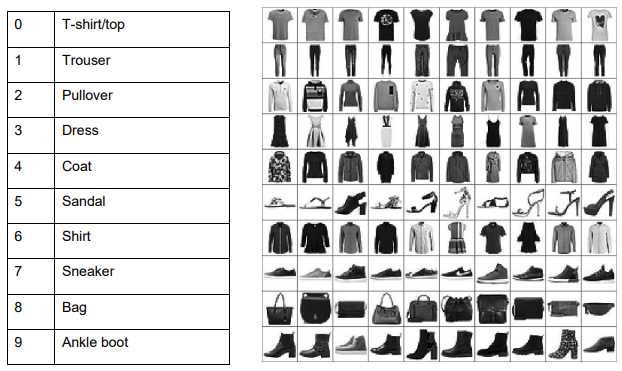

In [369]:
print('Train set:', train_images.shape, train_labels.shape)

Train set: (60000, 28, 28) (60000,)


In [370]:
print('Test set:', test_images.shape, test_labels.shape)

Test set: (10000, 28, 28) (10000,)


## Display images
### Display single image

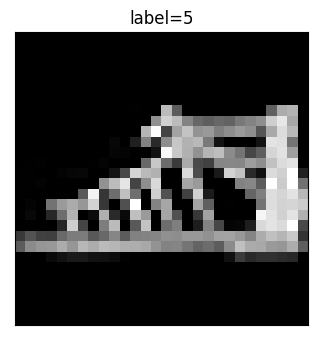

In [371]:
image_index = np.random.randint(low=0, high=len(train_labels), size=(1,)) # pick a random image index
image_vector = train_images[image_index] 
image_label = train_labels[image_index]

plt.figure()
plt.imshow(image_vector.reshape(28,28), cmap='gray')
plt.title(f"label={image_label.item()}")
plt.xticks([]);plt.yticks([]); 
#plt.xticks([]) and plt.yticks([]) are functions in the matplotlib.pyplot library that are used to remove tick marks and labels from the x and y axes of a plot, respectively.

### Display grid of images

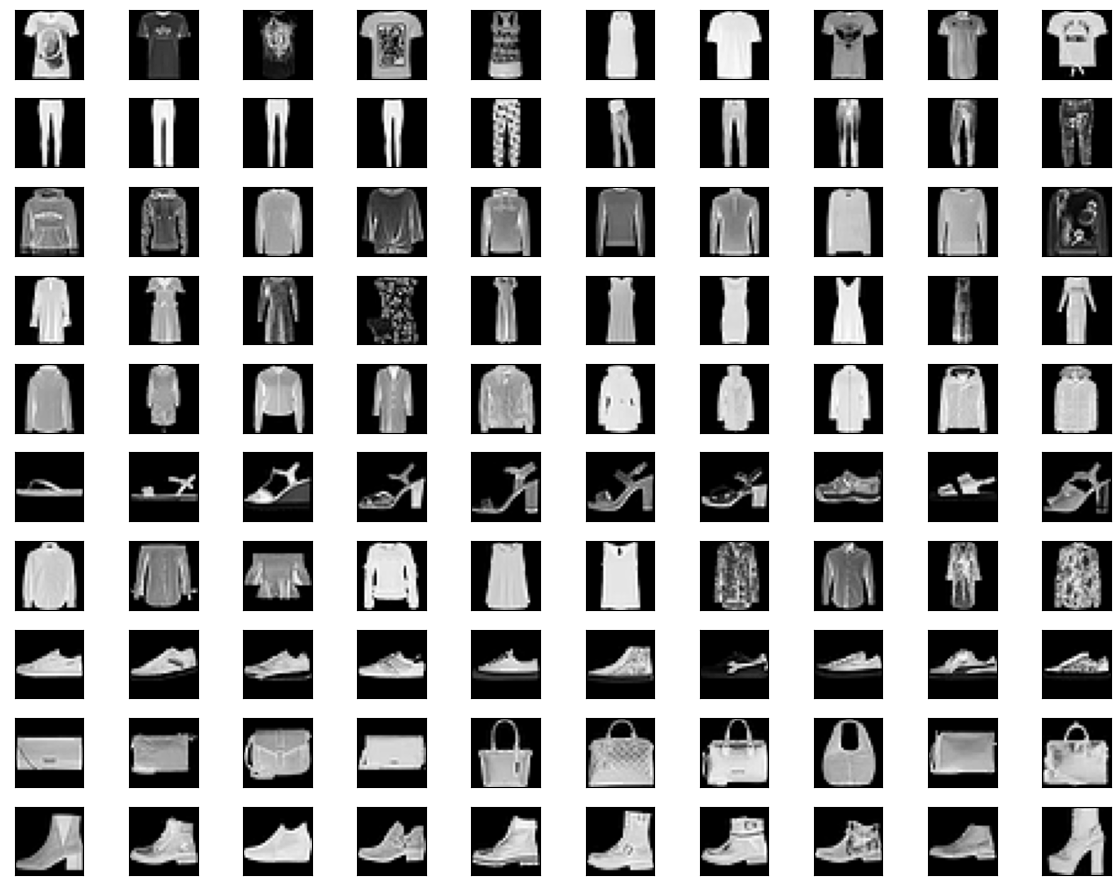

In [372]:
number_of_coulmns = 10

fig, ax = plt.subplots(ncols =number_of_coulmns, nrows=10, figsize=(12,9))

for digit in range(10):
    # select only images labeled with the current *digit*
    image_subset = train_images[train_labels==digit]
    # draw *number_of_coulmns* random images
    image_samples = np.random.randint(low=0, high= len(image_subset), size=(number_of_coulmns, ))
    for col_index, image_index in enumerate(image_samples): 
        ax[digit, col_index].imshow(image_subset[image_index], cmap='gray')        
        ax[digit, col_index].set_xticks([]);ax[digit, col_index].set_yticks([]); 

<font color='blue'> Let's check if the are they even separatable, before creating neural network with few hidden layers to classify images (using Dimensionality reduction):</font>

In [373]:
from sklearn.decomposition import PCA
pca = PCA(n_components=50)
mnist_train_vectors = train_images.reshape(train_images.shape[0], -1)
pca_vectors = pca.fit_transform( mnist_train_vectors )
print(f"PCA: reduced dimentions from {mnist_train_vectors.shape} to {pca_vectors.shape}")

PCA: reduced dimentions from (60000, 784) to (60000, 50)


<font color='blue'>"In order to further reduce the dimensionality of the data, I utilized t-SNE to map the data from 50 dimensions to 2 dimensions. This technique was selected as it is computationally more efficient compared to performing t-SNE on the original data directly." </font>

In [374]:
from openTSNE import TSNE
tsne  = TSNE(n_components=2, random_state=48, 
             exaggeration=1, n_jobs=int(os.cpu_count()/2))
tsne_vectors = tsne.fit(pca_vectors)

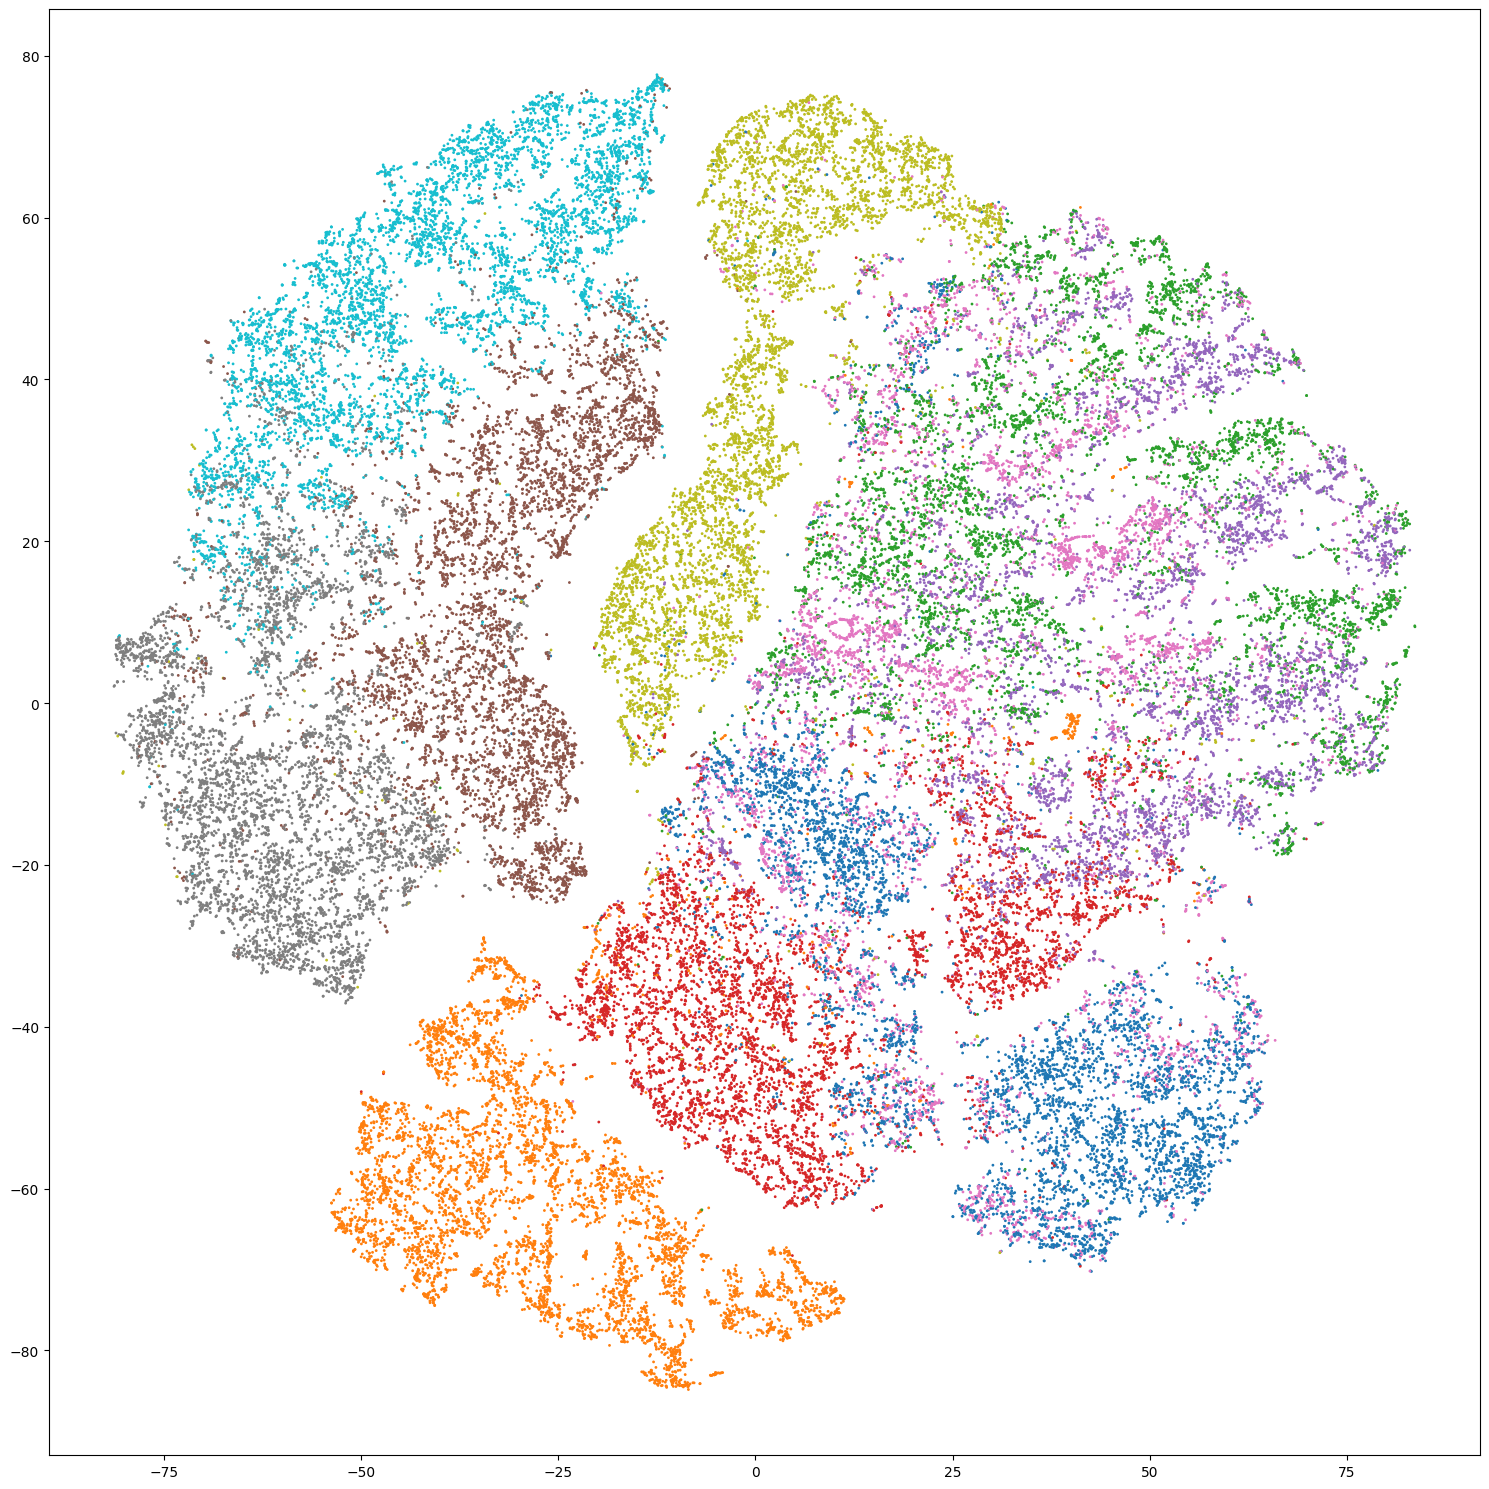

In [375]:
plt.subplots(figsize=(15,15))
plt.scatter(tsne_vectors[:,0], tsne_vectors[:,1], c=train_labels, s=1, cmap='tab10')

<font color='blue'>As depicted in the scatter plot, there is a clear differentiation between the various images in the dataset, but at the same time, the red, blue, green, and pink color clusters are not easily distinguishable, particularly the green and pink color clusters. What those clusters represent? </font>

In [387]:
import pandas as pd

In [388]:
data = pd.DataFrame(train_labels)

In [389]:
new_list= []
for i in range (0,60000):
     new_list.append([tsne_vectors[i,0],tsne_vectors[i,1]])
cordinates = pd.DataFrame(new_list)
data['x'] = cordinates[0]
data['y'] = cordinates[1]

In [390]:
data.head()

0          x          y
0  2  14.589707  53.504232
1  9 -59.811152  34.691246
2  6  56.563430   2.399838
3  0  40.330350 -50.745853
4  3  32.977343 -29.626207

In [391]:
new_list = []
i = 0
for index,row in data.iterrows():
    x = row['x']
    y = row['y']
    if x > 40 and x < 90:
             if y > 0 and y < 40:
                new_list.append(row[0])
    if i == 100:
        break;

In [392]:
data_sample = pd.DataFrame(new_list)

In [393]:
df1 = data_sample.groupby(0)[0].count()

In [394]:
df1

0
0.0       7
1.0      13
2.0    1692
3.0      14
4.0    1990
6.0    1193
8.0      16
Name: 0, dtype: int64

<font color='blue'>It can be inferred from the scatter plot that the colors green, purple, and pink exhibit indistinct clustering patterns with vague boundaries. These colors correspond to the categories of shirts, coats, and pullovers, which may explain the difficulty in separating them. </font> 

In [395]:
new_list1 = []
i = 0
for index,row in data.iterrows():
    x = row['x']
    y = row['y']
    if x > 40 and x < 75:
             if y > -70 and y <-40:
                new_list1.append(row[0])
    if i == 100:
        break;

In [396]:
data_sample1 = pd.DataFrame(new_list1)

In [397]:
df2 = data_sample1.groupby(0)[0].count()

In [398]:
df2

0
0.0    1910
2.0       4
3.0       5
4.0       2
6.0     299
Name: 0, dtype: int64

<font color='blue'>The scatter plot reveals that the color blue represents T-shirts / Tops, purple represents Shirts. The indistinct boundaries between blue and purple suggest a lack of clear differentiation between T-shirts and shirts, which is seems logically.</font> 

<font color='blue'>Why I did this? At the end in the confusion matrix I want to see how ANN handle this, and if not, maybe those crossed boundaries will be the reason. </font> 

#### Prepare the DATA (normalize the data)

In [229]:
print(f"mean: {train_images.mean()}\nstd: {train_images.std()}")
print(f"min: {train_images.min()}\nmax: {train_images.max()}")

mean: 72.9568306122449
std: 89.96686298512124
min: 0
max: 255


In [230]:
# normalize to [0..1] - I want that every pixel will be between 0 and 1. 
train_images_norm = (train_images-train_images.mean()) /train_images .std() 
test_images_norm = (test_images-train_images.mean()) /train_images.std()

In [231]:
print(f"mean: {train_images_norm.mean()}\nstd: {train_images_norm.std()}")
print(f"min: {train_images_norm.min()}\nmax: {train_images_norm.max()}")

mean: -1.8355687340469255e-16
std: 0.9999999999999977
min: -0.8109300268067647
max: 2.0234468930839733


###  -------------------------------------------------------------  MODEL 1 ---------------------------------------------------------------------------

In [556]:
from keras.models import Sequential
from keras.layers import Dense

model_1 = Sequential()
model_1.add(Dense(512, input_dim=28*28, activation='relu'))
model_1.add(Dense(450, activation='relu'))
model_1.add(Dense(10, activation='sigmoid'))

### Compile the model

In [557]:
import tensorflow as tf
model_1.compile(loss='categorical_crossentropy', optimizer='adam', metrics=[tf.metrics.mean_squared_error, tf.metrics.mean_absolute_error, 'accuracy'])

### Bring the data into a proper format: 
### images to vectors:  𝑁𝑥28𝑥28−>𝑁𝑥784
### labels to one-hot encoding:  𝑁−>𝑁𝑥10

In [558]:
train_images_norm = train_images_norm.reshape(-1, 28*28)
train_labels_onehot = pd.get_dummies(train_labels).values 
test_images_norm = test_images_norm.reshape(-1, 28*28)
test_labels_onehot = pd.get_dummies(test_labels).values

In [559]:
train_images_norm.shape, train_labels_onehot.shape

((60000, 784), (60000, 10))

### TRAINING

In [562]:
import time
start_time = time.time()
history = model_1.fit(train_images_norm, train_labels_onehot, epochs=15, batch_size = 100, verbose=2, shuffle = True,  validation_split=0.2)
train_time_model_1 = time.time() - start_time

Epoch 1/15
480/480 - 4s - loss: 0.4684 - mean_squared_error: 0.2083 - mean_absolute_error: 0.3001 - accuracy: 0.8280 - val_loss: 0.4059 - val_mean_squared_error: 0.1849 - val_mean_absolute_error: 0.2735 - val_accuracy: 0.8547 - 4s/epoch - 9ms/step
Epoch 2/15
480/480 - 3s - loss: 0.3512 - mean_squared_error: 0.1826 - mean_absolute_error: 0.2541 - accuracy: 0.8690 - val_loss: 0.3641 - val_mean_squared_error: 0.1905 - val_mean_absolute_error: 0.2507 - val_accuracy: 0.8692 - 3s/epoch - 6ms/step
Epoch 3/15
480/480 - 3s - loss: 0.3067 - mean_squared_error: 0.1769 - mean_absolute_error: 0.2391 - accuracy: 0.8859 - val_loss: 0.3322 - val_mean_squared_error: 0.1703 - val_mean_absolute_error: 0.2271 - val_accuracy: 0.8768 - 3s/epoch - 7ms/step
Epoch 4/15
480/480 - 3s - loss: 0.2821 - mean_squared_error: 0.1646 - mean_absolute_error: 0.2212 - accuracy: 0.8941 - val_loss: 0.3323 - val_mean_squared_error: 0.1704 - val_mean_absolute_error: 0.2192 - val_accuracy: 0.8814 - 3s/epoch - 7ms/step
Epoch 5/

In [564]:
print("Training Time:", train_time_model_1)

Training Time: 49.348236322402954


*Actually it can be seen in "executed in 49.4s... finished 17:22:46 2023-02-15"

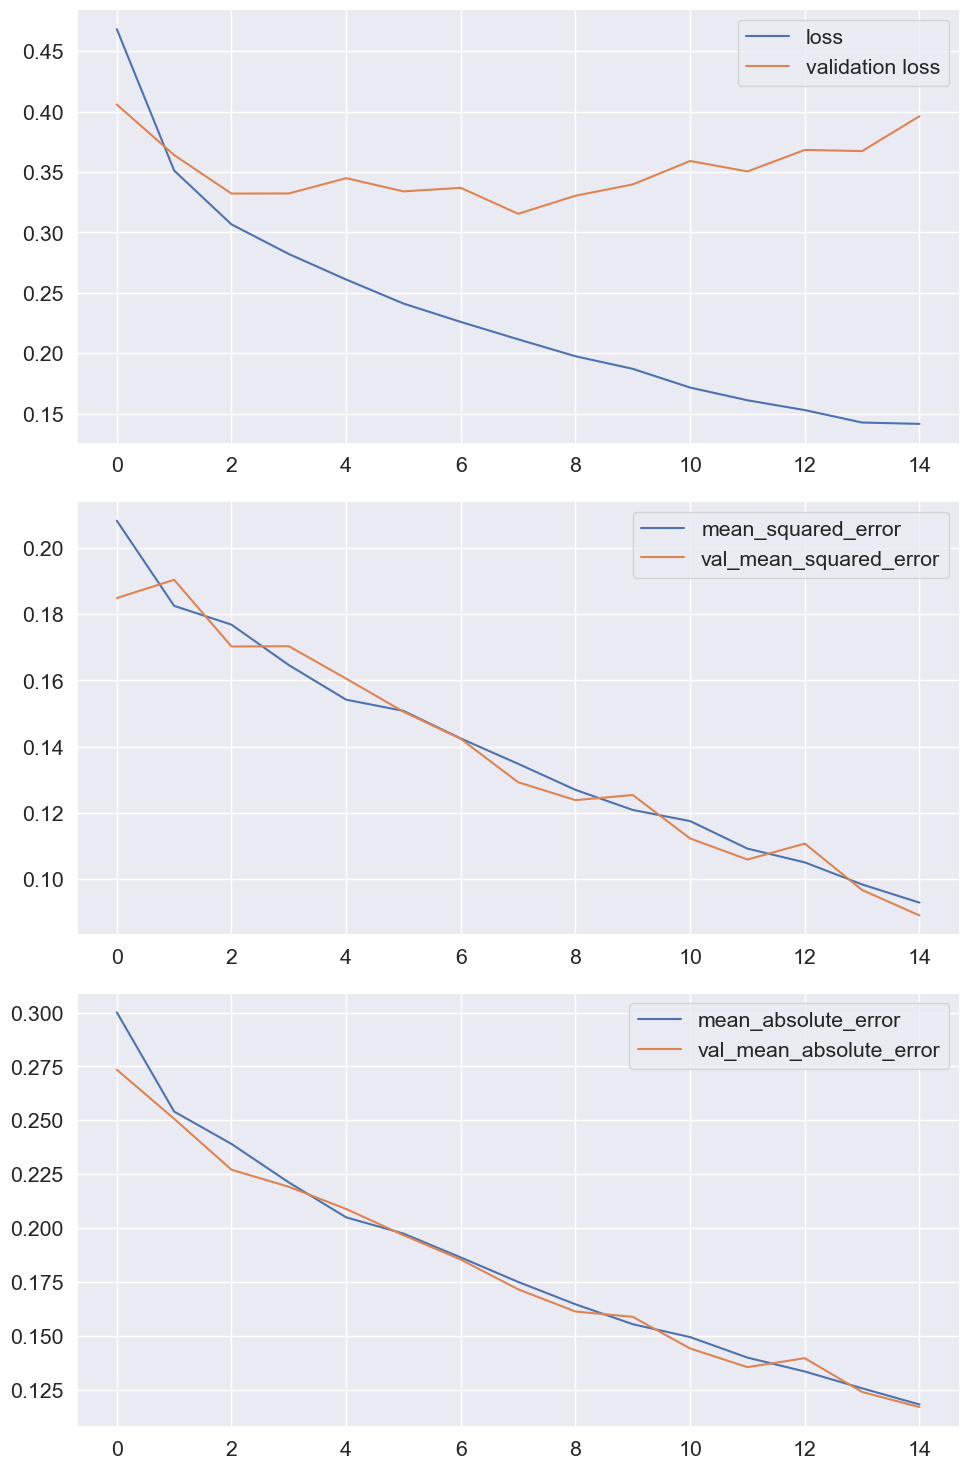

In [565]:
fig, ax = plt.subplots( 3 ,1, figsize=(10,15) )
ax[0].plot(history.history['loss'], label='loss')
ax[0].plot(history.history['val_loss'], label='validation loss')
ax[0].legend()

ax[1].plot(history.history['mean_squared_error'], label='mean_squared_error')
ax[1].plot(history.history['val_mean_squared_error'], label='val_mean_squared_error')
ax[1].legend()

ax[2].plot(history.history['mean_absolute_error'], label='mean_absolute_error')
ax[2].plot(history.history['val_mean_absolute_error'], label='val_mean_absolute_error')
ax[2].legend()

## <font color='blue'>According to the first grapth ( loss vs validation los ) we see that 15 epochs create a big difference between the validation loss and the training loss,
it is generally a bad sign because it indicates that the model is overfitting to the training data. 
In other words, the model is becoming too specialized in its ability to make predictions on the training data, but it may not generalize well to new data.
It's important to balance the model's ability to fit the training data well with its ability to generalize to new data.
So, in order to solve it, for this specific case, I will use 2-8 epochs, for example 7.
</font> 

In [699]:
model_1 = Sequential()
model_1.add(Dense(512, input_dim=28*28, activation='relu'))
model_1.add(Dense(450, activation='relu'))
model_1.add(Dense(10, activation='sigmoid'))

In [700]:
model_1.compile(loss='categorical_crossentropy', optimizer='adam', metrics=[tf.metrics.mean_squared_error, tf.metrics.mean_absolute_error, 'accuracy'])

### The network accuracy on the training and validation set (for each batch). 

In [701]:
start_time = time.time()
history_1 = model_1.fit(train_images_norm, train_labels_onehot, epochs=10, batch_size = 100, verbose=2, shuffle = True,  validation_split=0.2)
train_time_model_1 = time.time() - start_time

Epoch 1/10
480/480 - 4s - loss: 0.4638 - mean_squared_error: 0.2442 - mean_absolute_error: 0.3362 - accuracy: 0.8305 - val_loss: 0.3973 - val_mean_squared_error: 0.2251 - val_mean_absolute_error: 0.3010 - val_accuracy: 0.8532 - 4s/epoch - 8ms/step
Epoch 2/10
480/480 - 3s - loss: 0.3460 - mean_squared_error: 0.2062 - mean_absolute_error: 0.2809 - accuracy: 0.8736 - val_loss: 0.3604 - val_mean_squared_error: 0.2011 - val_mean_absolute_error: 0.2741 - val_accuracy: 0.8733 - 3s/epoch - 6ms/step
Epoch 3/10
480/480 - 3s - loss: 0.3094 - mean_squared_error: 0.1926 - mean_absolute_error: 0.2589 - accuracy: 0.8850 - val_loss: 0.3439 - val_mean_squared_error: 0.1942 - val_mean_absolute_error: 0.2540 - val_accuracy: 0.8748 - 3s/epoch - 6ms/step
Epoch 4/10
480/480 - 3s - loss: 0.2783 - mean_squared_error: 0.1801 - mean_absolute_error: 0.2389 - accuracy: 0.8953 - val_loss: 0.3284 - val_mean_squared_error: 0.1829 - val_mean_absolute_error: 0.2411 - val_accuracy: 0.8835 - 3s/epoch - 6ms/step
Epoch 5/

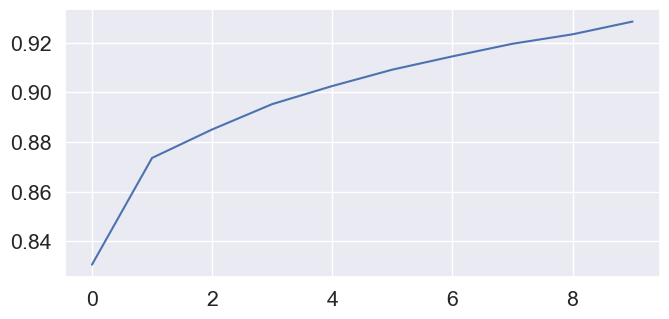

In [732]:
plt.plot(history_1.history['accuracy'])

In [702]:
print("Training Time:", train_time_model_1)

Training Time: 31.486509084701538


As we can see, we have even better results without overfiting and less training time.

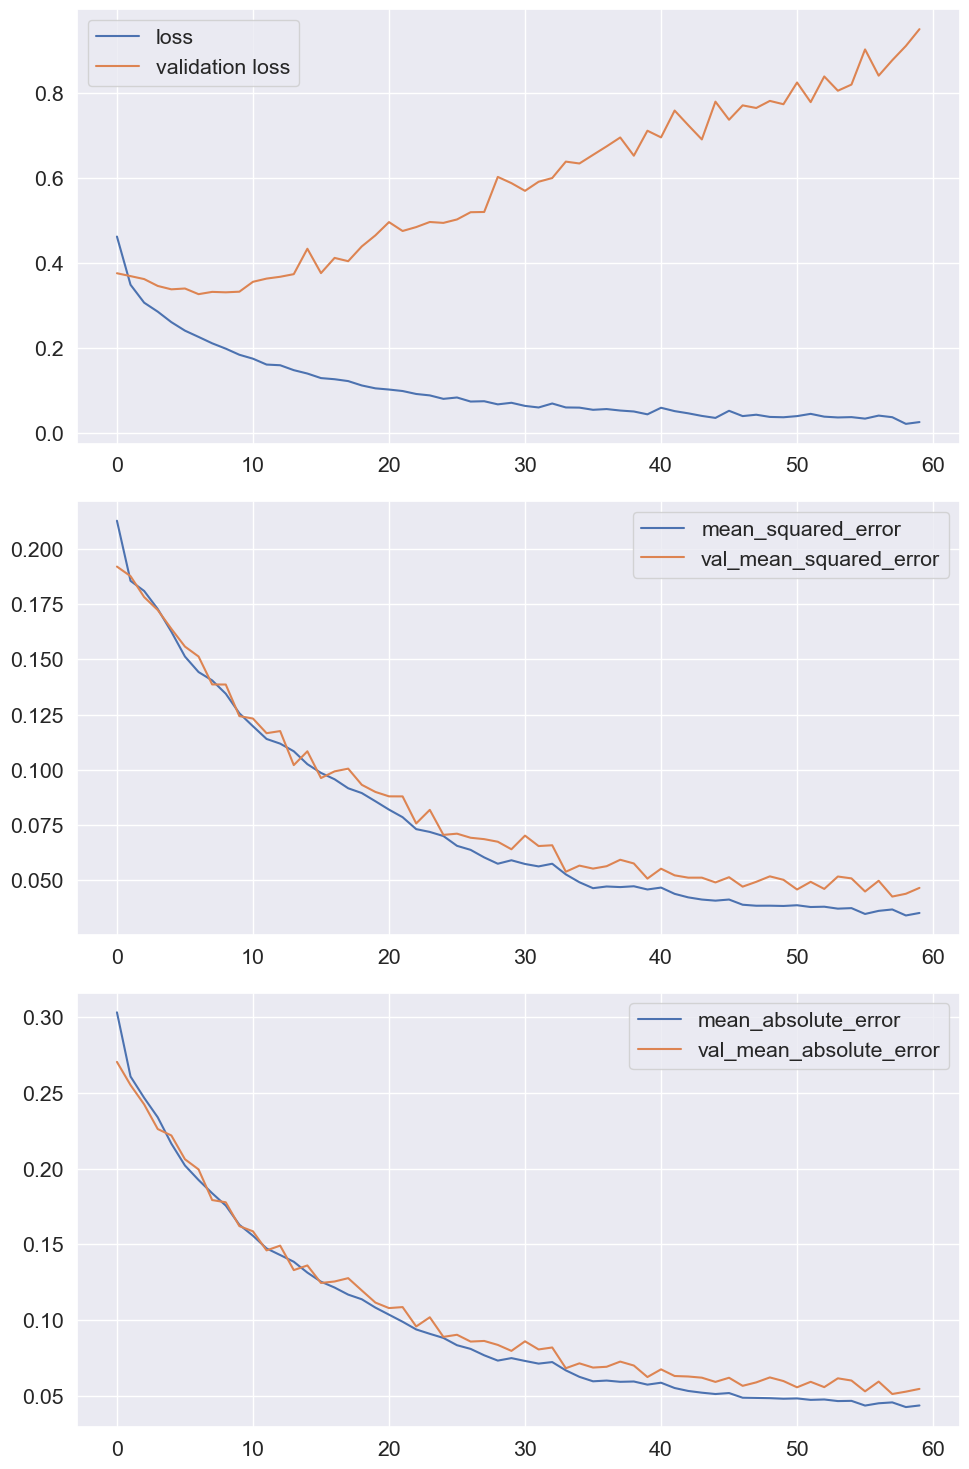

In [698]:
fig, ax = plt.subplots( 3 ,1, figsize=(10,15) )
ax[0].plot(history_1.history['loss'], label='loss')
ax[0].plot(history_1.history['val_loss'], label='validation loss')
ax[0].legend()

ax[1].plot(history_1.history['mean_squared_error'], label='mean_squared_error')
ax[1].plot(history_1.history['val_mean_squared_error'], label='val_mean_squared_error')
ax[1].legend()

ax[2].plot(history_1.history['mean_absolute_error'], label='mean_absolute_error')
ax[2].plot(history_1.history['val_mean_absolute_error'], label='val_mean_absolute_error')
ax[2].legend()

### Model 1 - The total number of network parameters 

In [703]:
model_1.summary() 

Model: "sequential_36"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_125 (Dense)           (None, 512)               401920    
                                                                 
 dense_126 (Dense)           (None, 450)               230850    
                                                                 
 dense_127 (Dense)           (None, 10)                4510      
                                                                 
Total params: 637,280
Trainable params: 637,280
Non-trainable params: 0
_________________________________________________________________


In [585]:
params_model_1 = model_1.count_params()

In [589]:
history_1.history.keys()

dict_keys(['loss', 'mean_squared_error', 'mean_absolute_error', 'accuracy', 'val_loss', 'val_mean_squared_error', 'val_mean_absolute_error', 'val_accuracy'])

In [591]:
_, mean_squared_error, mean_absolute_error, accuracy_model_1 = model_1.evaluate(train_images_norm, train_labels_onehot)

1875/1875 [==============================] - 4s 2ms/step - loss: 0.2296 - mean_squared_error: 0.1443 - mean_absolute_error: 0.1875 - accuracy: 0.9158


### Test the model ( + inference time ) 
- against train set

In [578]:
start_time = time.time()
_, accuracy_model_1, mean_squared_error,mean_absolute_error  = model_1.evaluate(test_images_norm, test_labels_onehot)
inference_time_model_1 = time.time() - start_time

313/313 [==============================] - 1s 2ms/step - loss: 0.3112 - mean_squared_error: 0.1309 - mean_absolute_error: 0.1728 - accuracy: 0.8864


# SUMMARY OF MODEL 1: 

In [624]:
print("Training Accuracy for each poch - model 1",(history_1.history['accuracy']),"\n")
#-------------------------------------------------------------------------------------------
print("MODEL 1:")
print("Parameters:", params_model_1)
print("Training Accuracy",(history_1.history['accuracy'][-1]))
print("Validation Accuracy:", (history_1.history['val_accuracy'][-1]))
print("Training Time:", train_time_model_1)
print("Inference Time:", inference_time_model_1)

Training Accuracy for each poch - model 1 [0.8298125267028809, 0.870270848274231, 0.8864791393280029, 0.8946041464805603, 0.901437520980835, 0.9087499976158142, 0.9126458168029785] 

MODEL 1:
Parameters: 637280
Training Accuracy 0.9126458168029785
Validation Accuracy: 0.8886666893959045
Training Time: 24.86283826828003
Inference Time: 0.6783773899078369


# ------------------------------------MODEL 2 ---------------------------------------------------------

In [613]:
model_2 = Sequential()
model_2.add(Dense(512, input_dim=28*28, activation='relu'))
model_2.add(Dense(450, activation='relu'))
model_2.add(Dense(300, activation='relu'))
model_2.add(Dense(150, activation='relu'))
model_2.add(Dense(10, activation='sigmoid'))

In [614]:
model_2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=[tf.metrics.mean_squared_error, tf.metrics.mean_absolute_error, 'accuracy'])

In [615]:
start_time = time.time()
history_2 = model_2.fit(train_images_norm, train_labels_onehot, epochs=6, batch_size = 100, verbose=2, shuffle = True,  validation_split=0.2)
train_time_model_2 = time.time() - start_time

Epoch 1/6
480/480 - 5s - loss: 0.4753 - mean_squared_error: 0.2497 - mean_absolute_error: 0.3579 - accuracy: 0.8277 - val_loss: 0.4125 - val_mean_squared_error: 0.2371 - val_mean_absolute_error: 0.3303 - val_accuracy: 0.8480 - 5s/epoch - 10ms/step
Epoch 2/6
480/480 - 5s - loss: 0.3553 - mean_squared_error: 0.2151 - mean_absolute_error: 0.2971 - accuracy: 0.8698 - val_loss: 0.4218 - val_mean_squared_error: 0.2027 - val_mean_absolute_error: 0.2842 - val_accuracy: 0.8497 - 5s/epoch - 9ms/step
Epoch 3/6
480/480 - 4s - loss: 0.3201 - mean_squared_error: 0.2074 - mean_absolute_error: 0.2757 - accuracy: 0.8814 - val_loss: 0.3845 - val_mean_squared_error: 0.2048 - val_mean_absolute_error: 0.2700 - val_accuracy: 0.8616 - 4s/epoch - 9ms/step
Epoch 4/6
480/480 - 4s - loss: 0.2919 - mean_squared_error: 0.1949 - mean_absolute_error: 0.2567 - accuracy: 0.8913 - val_loss: 0.3470 - val_mean_squared_error: 0.1944 - val_mean_absolute_error: 0.2524 - val_accuracy: 0.8769 - 4s/epoch - 9ms/step
Epoch 5/6
4

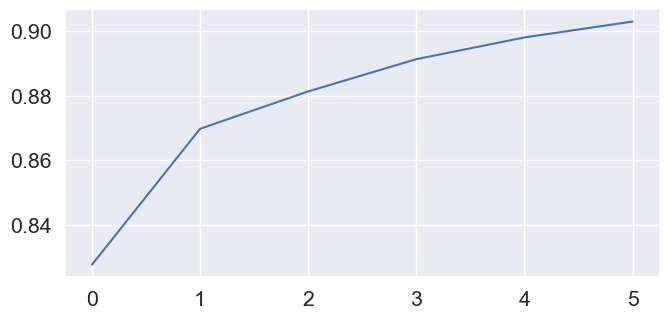

In [733]:
plt.plot(history_2.history['accuracy'])

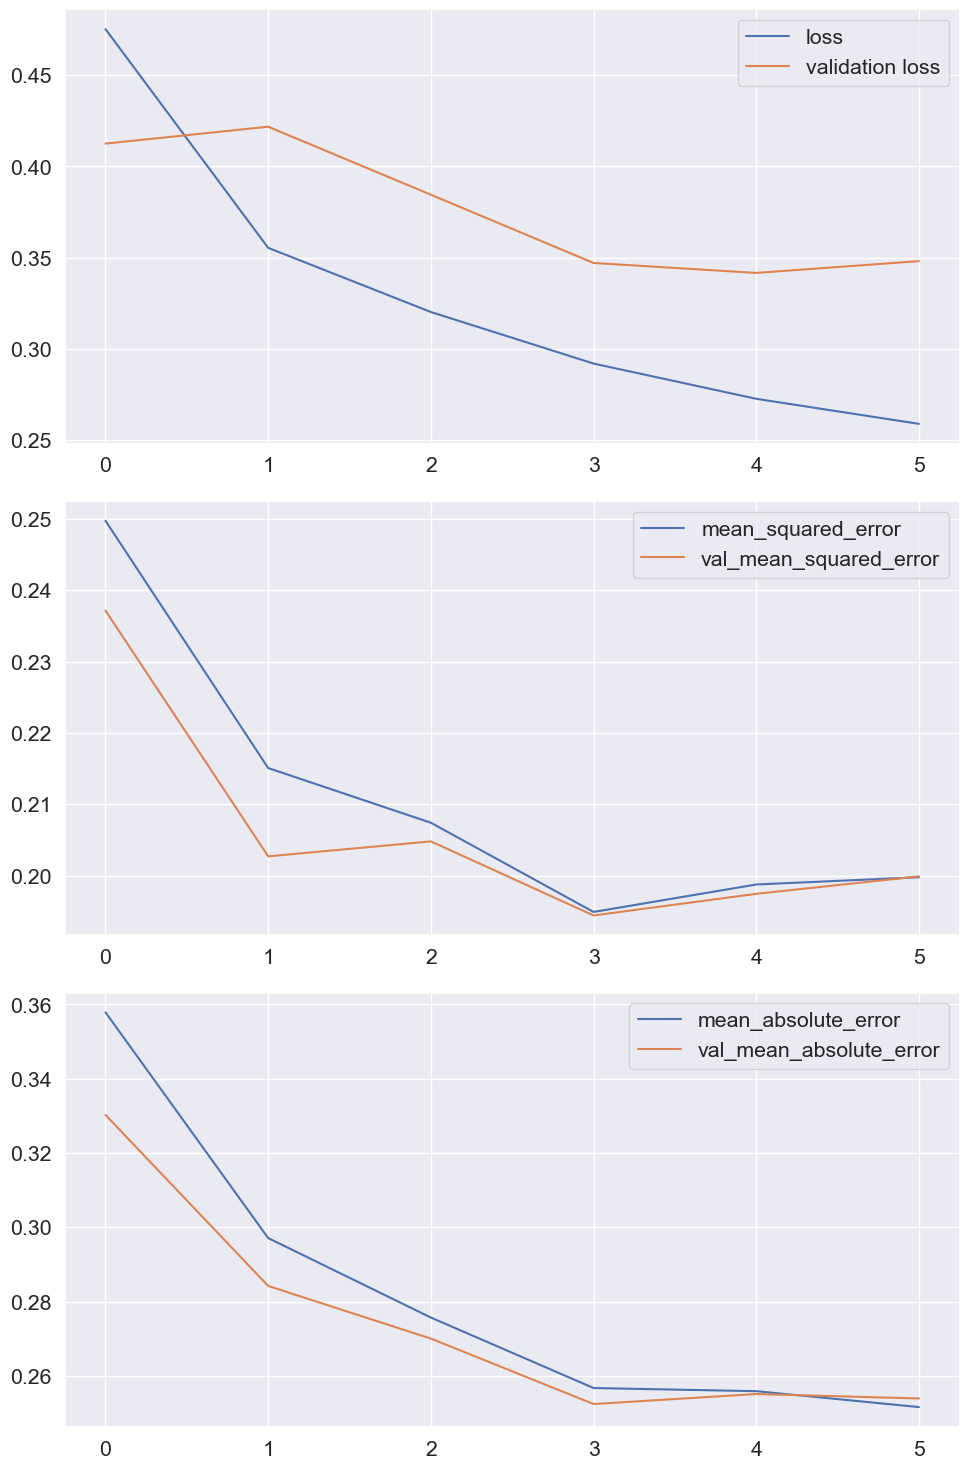

In [616]:
fig, ax = plt.subplots( 3 ,1, figsize=(10,15) )
ax[0].plot(history_2.history['loss'], label='loss')
ax[0].plot(history_2.history['val_loss'], label='validation loss')
ax[0].legend()

ax[1].plot(history_2.history['mean_squared_error'], label='mean_squared_error')
ax[1].plot(history_2.history['val_mean_squared_error'], label='val_mean_squared_error')
ax[1].legend()

ax[2].plot(history_2.history['mean_absolute_error'], label='mean_absolute_error')
ax[2].plot(history_2.history['val_mean_absolute_error'], label='val_mean_absolute_error')
ax[2].legend()

I automatically change the number of epochs, because when it was 15 - there val_loss after 7 started to climb.

In [617]:
model_2.summary() 

Model: "sequential_30"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_102 (Dense)           (None, 512)               401920    
                                                                 
 dense_103 (Dense)           (None, 450)               230850    
                                                                 
 dense_104 (Dense)           (None, 300)               135300    
                                                                 
 dense_105 (Dense)           (None, 150)               45150     
                                                                 
 dense_106 (Dense)           (None, 10)                1510      
                                                                 
Total params: 814,730
Trainable params: 814,730
Non-trainable params: 0
_________________________________________________________________


In [618]:
params_model_2 = model_2.count_params()

In [619]:
_, mean_squared_error, mean_absolute_error, accuracy_model_2 = model_2.evaluate(train_images_norm, train_labels_onehot)

1875/1875 [==============================] - 5s 3ms/step - loss: 0.2698 - mean_squared_error: 0.1993 - mean_absolute_error: 0.2529 - accuracy: 0.8991


In [620]:
start_time = time.time()
_, accuracy_model_2, mean_squared_error,mean_absolute_error  = model_2.evaluate(test_images_norm, test_labels_onehot)
inference_time_model_2 = time.time() - start_time

313/313 [==============================] - 1s 3ms/step - loss: 0.3342 - mean_squared_error: 0.2003 - mean_absolute_error: 0.2538 - accuracy: 0.8805


In [ ]:
# SUMMARY OF MODEL 2: 

In [656]:
print("Training Accuracy for each epoch - model 2",(history_2.history['accuracy']),"\n")
#-------------------------------------------------------------------------------------------
print("MODEL 2:")
print("Parameters:", params_model_2)
print("Training Accuracy Mean ",(history_2.history['accuracy'][-1]))
print("Validation Accuracy Mean:", (history_2.history['val_accuracy'][-1]))
print("Training Time:", train_time_model_2)
print("Inference Time:", inference_time_model_2)

Training Accuracy for each epoch - model 2 [0.8277291655540466, 0.8697916865348816, 0.8813541531562805, 0.8913333415985107, 0.898062527179718, 0.9029791951179504] 

MODEL 2:
Parameters: 814730
Training Accuracy Mean  0.9029791951179504
Validation Accuracy Mean: 0.8754166960716248
Training Time: 27.14873957633972
Inference Time: 0.8703248500823975


# ---------------------------------------MODEL 3 -----------------------------------------------------

In [626]:
model_3 = Sequential()
model_3.add(Dense(784, input_dim=28*28, activation='relu'))
model_3.add(Dense(1000, activation='relu'))
model_3.add(Dense(1500, activation='relu'))
model_3.add(Dense(250, activation='relu'))
model_3.add(Dense(10, activation='sigmoid'))

In [627]:
model_3.compile(loss='categorical_crossentropy', optimizer='adam', metrics=[tf.metrics.mean_squared_error, tf.metrics.mean_absolute_error, 'accuracy'])

In [628]:
start_time = time.time()
history_3 = model_3.fit(train_images_norm, train_labels_onehot, epochs=15, batch_size = 100, verbose=2, shuffle = True,  validation_split=0.2)
train_time_model_3 = time.time() - start_time

Epoch 1/15
480/480 - 16s - loss: 0.4836 - mean_squared_error: 0.2280 - mean_absolute_error: 0.3176 - accuracy: 0.8269 - val_loss: 0.4013 - val_mean_squared_error: 0.2191 - val_mean_absolute_error: 0.2950 - val_accuracy: 0.8531 - 16s/epoch - 33ms/step
Epoch 2/15
480/480 - 16s - loss: 0.3630 - mean_squared_error: 0.2300 - mean_absolute_error: 0.2977 - accuracy: 0.8671 - val_loss: 0.3700 - val_mean_squared_error: 0.2405 - val_mean_absolute_error: 0.3080 - val_accuracy: 0.8631 - 16s/epoch - 32ms/step
Epoch 3/15
480/480 - 15s - loss: 0.3255 - mean_squared_error: 0.2301 - mean_absolute_error: 0.2899 - accuracy: 0.8800 - val_loss: 0.3921 - val_mean_squared_error: 0.2346 - val_mean_absolute_error: 0.2978 - val_accuracy: 0.8581 - 15s/epoch - 32ms/step
Epoch 4/15
480/480 - 15s - loss: 0.2962 - mean_squared_error: 0.2235 - mean_absolute_error: 0.2764 - accuracy: 0.8883 - val_loss: 0.3477 - val_mean_squared_error: 0.2209 - val_mean_absolute_error: 0.2820 - val_accuracy: 0.8788 - 15s/epoch - 31ms/s

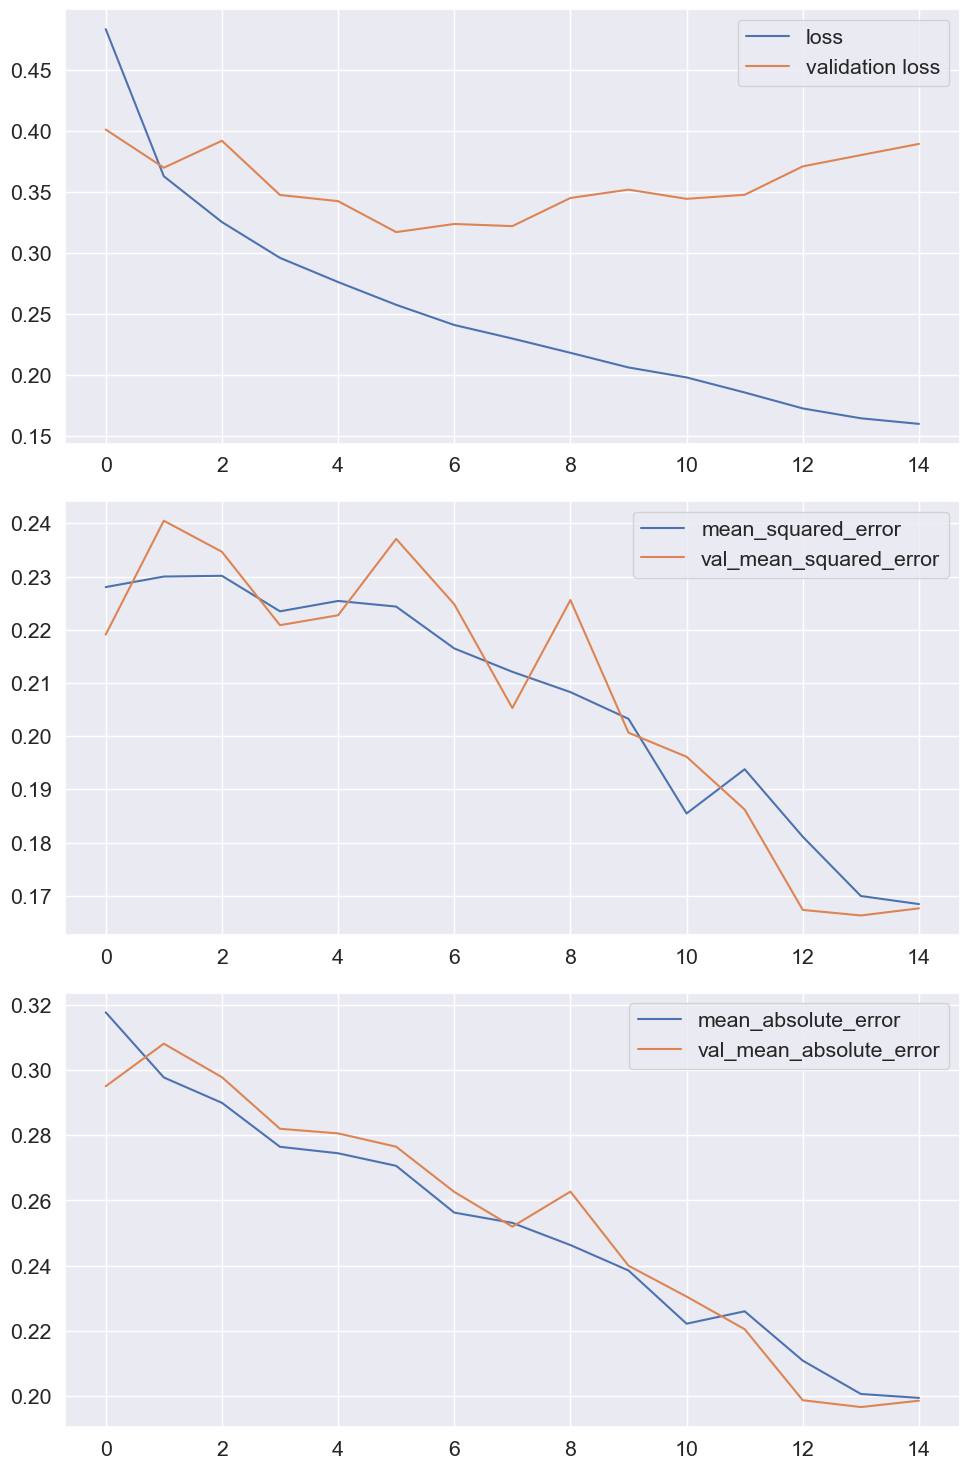

In [629]:
fig, ax = plt.subplots( 3 ,1, figsize=(10,15) )
ax[0].plot(history_3.history['loss'], label='loss')
ax[0].plot(history_3.history['val_loss'], label='validation loss')
ax[0].legend()

ax[1].plot(history_3.history['mean_squared_error'], label='mean_squared_error')
ax[1].plot(history_3.history['val_mean_squared_error'], label='val_mean_squared_error')
ax[1].legend()

ax[2].plot(history_3.history['mean_absolute_error'], label='mean_absolute_error')
ax[2].plot(history_3.history['val_mean_absolute_error'], label='val_mean_absolute_error')
ax[2].legend()

In [630]:
model_3.summary() 

Model: "sequential_31"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_107 (Dense)           (None, 784)               615440    
                                                                 
 dense_108 (Dense)           (None, 1000)              785000    
                                                                 
 dense_109 (Dense)           (None, 1500)              1501500   
                                                                 
 dense_110 (Dense)           (None, 250)               375250    
                                                                 
 dense_111 (Dense)           (None, 10)                2510      
                                                                 
Total params: 3,279,700
Trainable params: 3,279,700
Non-trainable params: 0
_________________________________________________________________


In [631]:
params_model_3 = model_3.count_params()

In [ ]:
_, mean_squared_error, mean_absolute_error, accuracy_model_3 = model_3.evaluate(train_images_norm, train_labels_onehot)

In [632]:
start_time = time.time()
_, accuracy_model_3, mean_squared_error,mean_absolute_error  = model_3.evaluate(test_images_norm, test_labels_onehot)
inference_time_model_3 = time.time() - start_time

313/313 [==============================] - 2s 5ms/step - loss: 0.3824 - mean_squared_error: 0.1684 - mean_absolute_error: 0.1987 - accuracy: 0.8810


# SUMMARY OF MODEL 3: 

In [655]:
print("Training Accuracy for each epoch - model 3",(history_3.history['accuracy']),"\n")
#-------------------------------------------------------------------------------------------
print("MODEL 3:")
print("Parameters:", params_model_3)
print("Training Accuracy Mean ",(history_3.history['accuracy'][-1]))
print("Validation Accuracy Mean:", (history_3.history['val_accuracy'][-1]))
print("Training Time:", train_time_model_3)
print("Inference Time:", inference_time_model_3)

Training Accuracy for each epoch - model 3 [0.8268749713897705, 0.8671249747276306, 0.8799791932106018, 0.8883333206176758, 0.8946874737739563, 0.903208315372467, 0.9085208177566528, 0.9127500057220459, 0.9162916541099548, 0.9180625081062317, 0.9235000014305115, 0.9244375228881836, 0.9235625267028809, 0.9255833625793457, 0.9322916865348816] 

MODEL 3:
Parameters: 3279700
Training Accuracy Mean  0.9322916865348816
Validation Accuracy Mean: 0.8814166784286499
Training Time: 235.0800120830536
Inference Time: 1.6754417419433594


# ---------------------------------------MODEL 4 -----------------------------------------------------

In [644]:
model_4 = Sequential()
model_4.add(Dense(100, input_dim=28*28, activation='relu'))
model_4.add(Dense(10, activation='sigmoid'))

In [645]:
model_4.compile(loss='categorical_crossentropy', optimizer='adam', metrics=[tf.metrics.mean_squared_error, tf.metrics.mean_absolute_error, 'accuracy'])

In [646]:
start_time = time.time()
history_4 = model_4.fit(train_images_norm, train_labels_onehot, epochs=15, batch_size = 100, verbose=2, shuffle = True,  validation_split=0.2)
train_time_model_4 = time.time() - start_time

Epoch 1/15
480/480 - 2s - loss: 0.5072 - mean_squared_error: 0.2703 - mean_absolute_error: 0.3655 - accuracy: 0.8179 - val_loss: 0.4145 - val_mean_squared_error: 0.2478 - val_mean_absolute_error: 0.3379 - val_accuracy: 0.8512 - 2s/epoch - 3ms/step
Epoch 2/15
480/480 - 1s - loss: 0.3781 - mean_squared_error: 0.2402 - mean_absolute_error: 0.3235 - accuracy: 0.8623 - val_loss: 0.3930 - val_mean_squared_error: 0.2405 - val_mean_absolute_error: 0.3219 - val_accuracy: 0.8561 - 922ms/epoch - 2ms/step
Epoch 3/15
480/480 - 1s - loss: 0.3398 - mean_squared_error: 0.2236 - mean_absolute_error: 0.2997 - accuracy: 0.8766 - val_loss: 0.3747 - val_mean_squared_error: 0.2209 - val_mean_absolute_error: 0.2938 - val_accuracy: 0.8677 - 924ms/epoch - 2ms/step
Epoch 4/15
480/480 - 1s - loss: 0.3164 - mean_squared_error: 0.2191 - mean_absolute_error: 0.2893 - accuracy: 0.8841 - val_loss: 0.3546 - val_mean_squared_error: 0.2158 - val_mean_absolute_error: 0.2862 - val_accuracy: 0.8733 - 927ms/epoch - 2ms/step

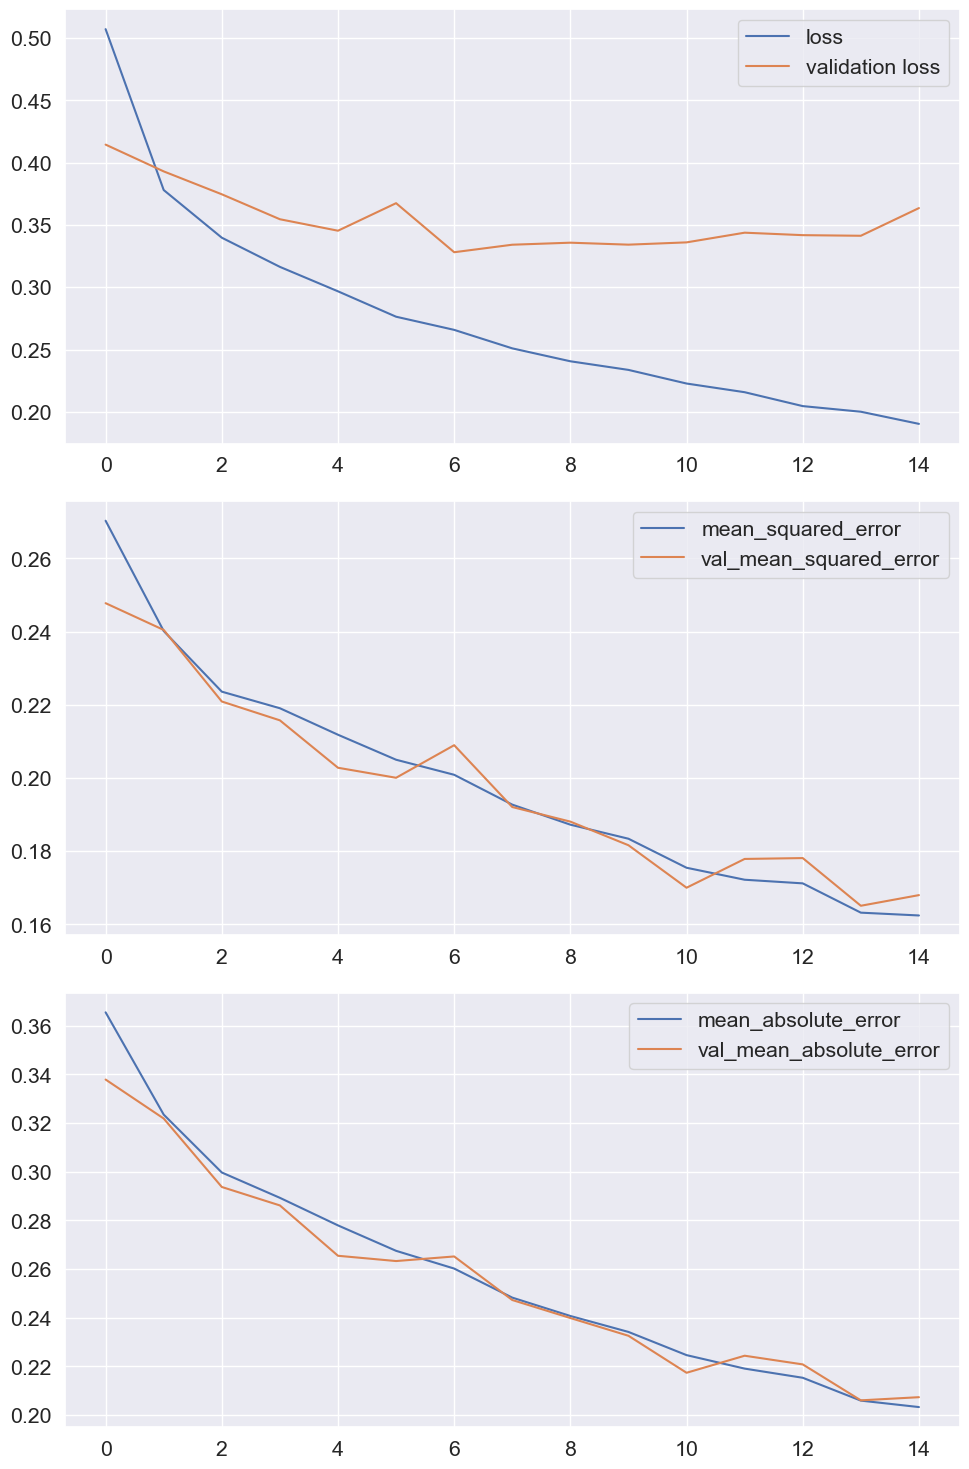

In [647]:
fig, ax = plt.subplots( 3 ,1, figsize=(10,15) )
ax[0].plot(history_4.history['loss'], label='loss')
ax[0].plot(history_4.history['val_loss'], label='validation loss')
ax[0].legend()

ax[1].plot(history_4.history['mean_squared_error'], label='mean_squared_error')
ax[1].plot(history_4.history['val_mean_squared_error'], label='val_mean_squared_error')
ax[1].legend()

ax[2].plot(history_4.history['mean_absolute_error'], label='mean_absolute_error')
ax[2].plot(history_4.history['val_mean_absolute_error'], label='val_mean_absolute_error')
ax[2].legend()

In [648]:
model_4.summary() 

Model: "sequential_34"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_120 (Dense)           (None, 100)               78500     
                                                                 
 dense_121 (Dense)           (None, 10)                1010      
                                                                 
Total params: 79,510
Trainable params: 79,510
Non-trainable params: 0
_________________________________________________________________


In [649]:
params_model_4 = model_4.count_params()

In [650]:
_, mean_squared_error, mean_absolute_error, accuracy_model_4 = model_4.evaluate(train_images_norm, train_labels_onehot)

1875/1875 [==============================] - 2s 976us/step - loss: 0.2181 - mean_squared_error: 0.1658 - mean_absolute_error: 0.2051 - accuracy: 0.9225


In [651]:
start_time = time.time()
_, accuracy_model_4, mean_squared_error,mean_absolute_error  = model_3.evaluate(test_images_norm, test_labels_onehot)
inference_time_model_4 = time.time() - start_time

313/313 [==============================] - 2s 5ms/step - loss: 0.3824 - mean_squared_error: 0.1684 - mean_absolute_error: 0.1987 - accuracy: 0.8810


In [652]:
# SUMMARY OF MODEL 4: 

In [654]:
print("Training Accuracy for each epoch - model 4",(history_3.history['accuracy']),"\n")
#-------------------------------------------------------------------------------------------
print("MODEL 4:")
print("Parameters:", params_model_4)
print("Training Accuracy Mean ",(history_4.history['accuracy'][-1]))
print("Validation Accuracy Mean:", (history_4.history['val_accuracy'][-1]))
print("Training Time:", train_time_model_4)
print("Inference Time:", inference_time_model_4)

Training Accuracy for each epoch - model 4 [0.8268749713897705, 0.8671249747276306, 0.8799791932106018, 0.8883333206176758, 0.8946874737739563, 0.903208315372467, 0.9085208177566528, 0.9127500057220459, 0.9162916541099548, 0.9180625081062317, 0.9235000014305115, 0.9244375228881836, 0.9235625267028809, 0.9255833625793457, 0.9322916865348816] 

MODEL 4:
Parameters: 79510
Training Accuracy Mean  0.9285625219345093
Validation Accuracy Mean: 0.8815000057220459
Training Time: 14.780575275421143
Inference Time: 1.5965750217437744


# Summary:

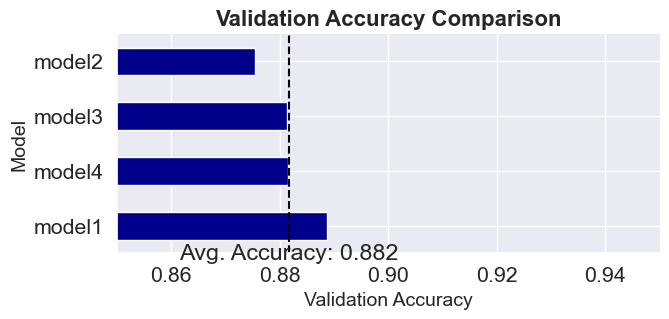

In [714]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# create the dictionary of model data
model_data = {'model1': {'Validation Accuracy': 0.8886666893959045},
              'model2': {'Validation Accuracy': 0.8754166960716248},
              'model3': {'Validation Accuracy': 0.8814166784286499},
              'model4': {'Validation Accuracy': 0.8815000057220459}}

# create a dataframe from the dictionary
df = pd.DataFrame(model_data).T

# sort the dataframe by validation accuracy
df.sort_values('Validation Accuracy', ascending=False, inplace=True)

# set the seaborn style
sns.set_style('darkgrid')

# create the horizontal bar chart
ax = df.plot(kind='barh', legend=False, color='darkblue')

# add a horizontal line for the average accuracy
avg_acc = df['Validation Accuracy'].mean()
ax.axvline(x=avg_acc, color='black', linestyle='--')
ax.text(avg_acc, -0.5, f'Avg. Accuracy: {avg_acc:.3f}', ha='center', va='center')

# set the title and labels
ax.set_title('Validation Accuracy Comparison', fontsize=16, fontweight='bold')
ax.set_xlabel('Validation Accuracy', fontsize=14)
ax.set_ylabel('Model', fontsize=14)

# set the x-axis limits
ax.set_xlim([0.85, 0.95])

# remove the spines on the top and right sides
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# show the chart

As we can see from the grapth, there is better accuracy of the model 1, then 4, 3 and 2. What about overfiting and time consuming?

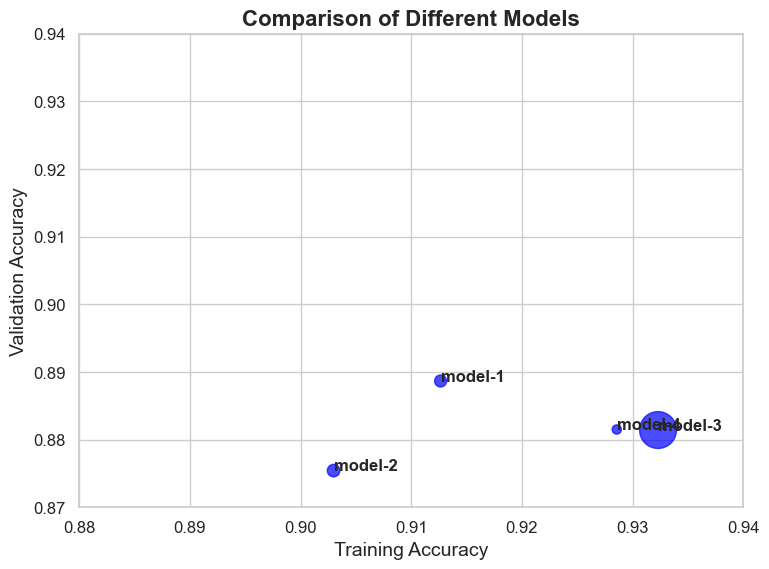

In [719]:
data = {
    'model1': ['model-1',  0.9126458168029785, 0.8886666893959045, 24.86283826828003],
    'model2': ['model-2',  0.9029791951179504, 0.8754166960716248, 27.14873957633972],
    'model3': ['model-3',  0.9322916865348816, 0.8814166784286499, 235.0800120830536],
    'model4': ['model-4',  0.9285625219345093, 0.8815000057220459, 14.780575275421143]
}

df = pd.DataFrame.from_dict(data, orient='index', columns=['Model', 'Training Accuracy', 'Validation Accuracy', 'Training Time'])

# set style to whitegrid
sns.set_style('whitegrid')

# create the scatter plot
plt.figure(figsize=(8,6))
plt.scatter(df['Training Accuracy'], df['Validation Accuracy'], s=df['Training Time']*3, alpha=0.7, color='blue')
plt.xlabel('Training Accuracy', fontsize=14)
plt.ylabel('Validation Accuracy', fontsize=14)
plt.title('Comparison of Different Models', fontsize=16, fontweight='bold')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlim([0.88, 0.94])
plt.ylim([0.87, 0.94])

# add text labels to each point
for i, row in df.iterrows():
    plt.annotate(row['Model'], (row['Training Accuracy'], row['Validation Accuracy']), fontsize=12, fontweight='bold')

plt.show()

After analyzing the scatter plot, it appears that model-1 has a small difference between the training accuracy and validation accuracy when compared to the other models. The size of the circle in the scatter plot represents the time it took to train each model, and it shows that model-1 took slightly more time to train than model-4, but less time than model-3.

Although there are slight differences between the models, the differences in training time between model 1,2,4 and inference time are not significant. Based on this analysis, I would recommend selecting model-1 as the preferred model.

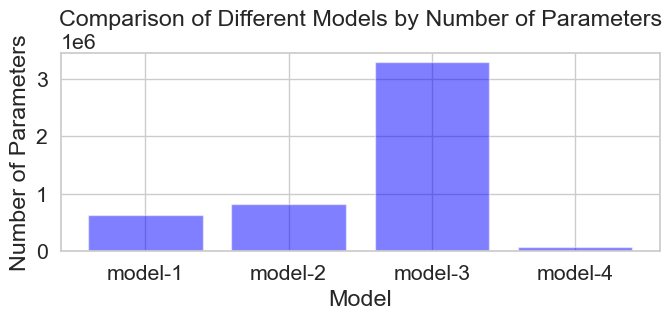

In [720]:
data = {
    'model1': ['model-1', 637280],
    'model2': ['model-2', 814730],
    'model3': ['model-3', 3279700],
    'model4': ['model-4', 79510]
}

df = pd.DataFrame.from_dict(data, orient='index', columns=['Model', 'Number of Parameters'])

fig, ax = plt.subplots()

ax.bar(df['Model'], df['Number of Parameters'], color='blue', alpha=0.5)
ax.set_xlabel('Model')
ax.set_ylabel('Number of Parameters')
ax.set_title('Comparison of Different Models by Number of Parameters')

plt.show()

## From this grapth, multiple number of parameters not givings as a better results (Model 2 and Model 3 have significantly more parameters than Model 1, but their accuracy is not much better). On the other hand, small number of parameters can have an impact on the accuracy. Model 4 , which has the fewest parameters, may be underfitting the data, leading to lower accuracy.Model 1, with a reasonable number of parameters, appears to strike a good balance between complexity and performance. 

####  prediction accuracy (fraction of correctly predicted digits)

In [723]:
predicted_labels = np.argmax(model_1(train_images_norm), axis=1)
(predicted_labels == train_labels).mean()

0.92865

In [724]:
predicted_labels = np.argmax(model_1.predict(test_images_norm), axis=1)
(predicted_labels == test_labels).mean()

313/313 [==============================] - 1s 3ms/step


0.8924

confusion matrix

In [725]:
from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(y_true=test_labels, y_pred=predicted_labels)
conf_mat

array([[884,   3,  19,  22,   2,   0,  62,   1,   7,   0],
       [  4, 988,   0,   7,   0,   0,   1,   0,   0,   0],
       [ 11,   0, 822,  10, 105,   0,  51,   0,   1,   0],
       [ 20,  13,  12, 901,  40,   0,  12,   0,   2,   0],
       [  0,   2,  52,  16, 881,   0,  47,   0,   2,   0],
       [  0,   0,   0,   1,   0, 911,   0,  62,   4,  22],
       [177,   2,  85,  27,  65,   0, 638,   0,   6,   0],
       [  0,   0,   0,   0,   0,   2,   0, 964,   0,  34],
       [  4,   1,   9,   1,   3,   1,   5,   2, 971,   3],
       [  0,   0,   0,   0,   0,   2,   0,  34,   0, 964]], dtype=int64)

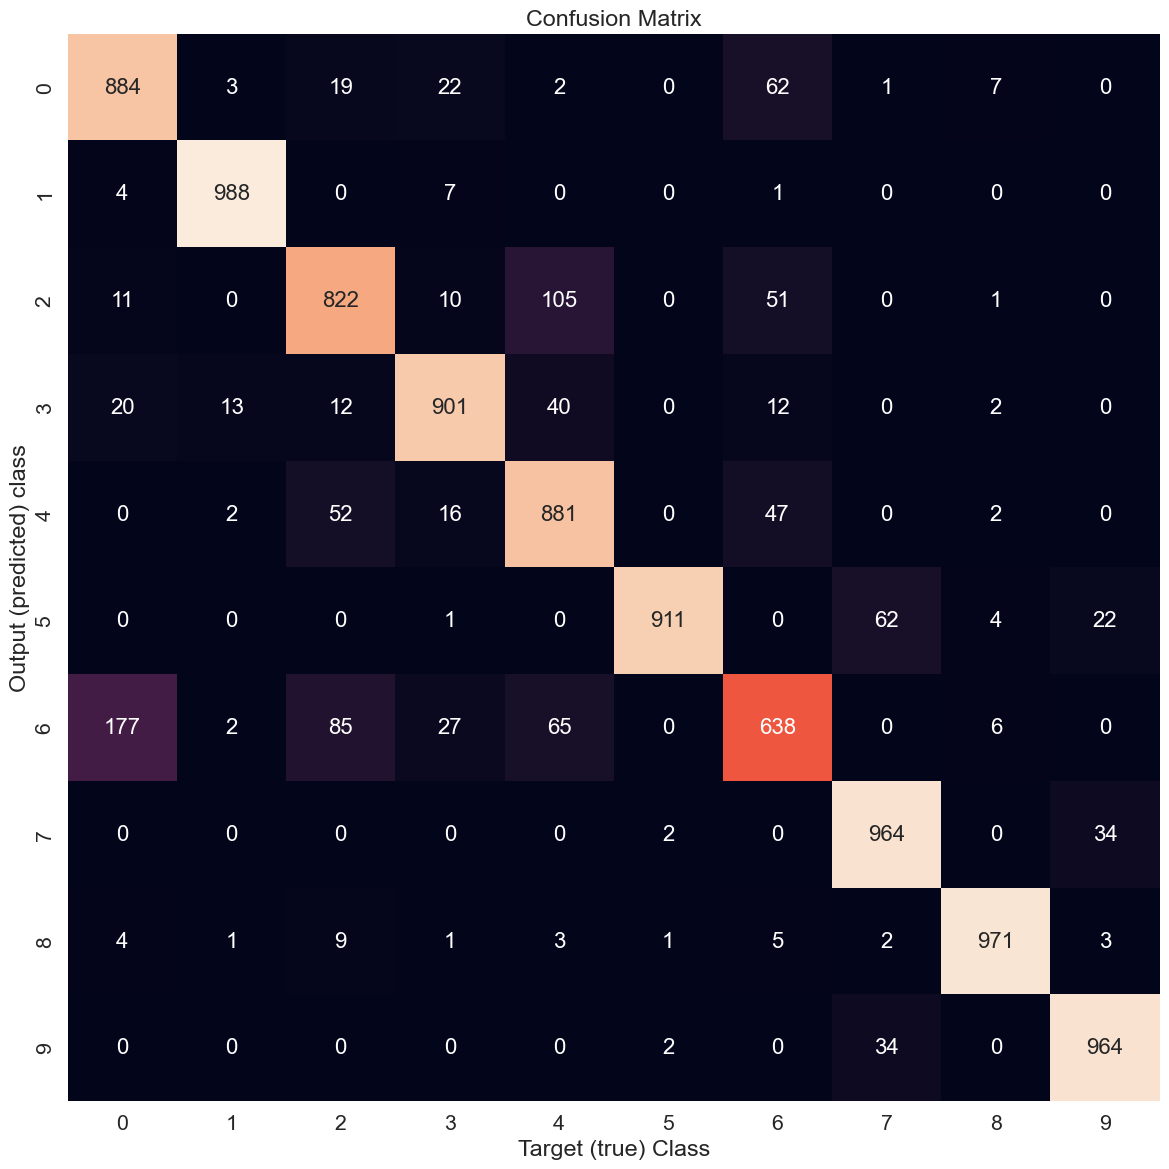

In [726]:
import seaborn as sn

#plot_confusion_matrix(estimator=model, X=test_images_norm, y_true=test_labels )
plt.subplots(figsize=(12,12))
sn.set(font_scale=1.4) # for label size
sn.heatmap(conf_mat, annot=True, fmt=".0f", annot_kws={"size": 16}, cbar=False) # font size
plt.xlabel('Target (true) Class'); plt.ylabel('Output (predicted) class'); plt.title('Confusion Matrix')
plt.show()

In [727]:
for layer_index, layer in enumerate(model_1.layers):
    print(f"Layer #{layer_index}, name: {layer.name}")
    print(f"\tWeights:")
    for i in range(len(layer.weights)):
        print(f"\t\t{i}. {layer.weights[i].shape}")
    print(f'\tActivation: {layer.activation}')
    #for parameter_index, p in enumerate(layer.parameters()):
    #    print(f"layer: {layer_index}, parameter: {parameter_index}, {p.shape}")
    pass

Layer #0, name: dense_125
	Weights:
		0. (784, 512)
		1. (512,)
	Activation: <function relu at 0x0000024490D26280>
Layer #1, name: dense_126
	Weights:
		0. (512, 450)
		1. (450,)
	Activation: <function relu at 0x0000024490D26280>
Layer #2, name: dense_127
	Weights:
		0. (450, 10)
		1. (10,)
	Activation: <function sigmoid at 0x0000024490D26790>


## Run & display predictions
- make predictions

In [728]:
predicted_label = np.argmax( model_1(test_images_norm.reshape(-1, 28*28)) , axis=1) 

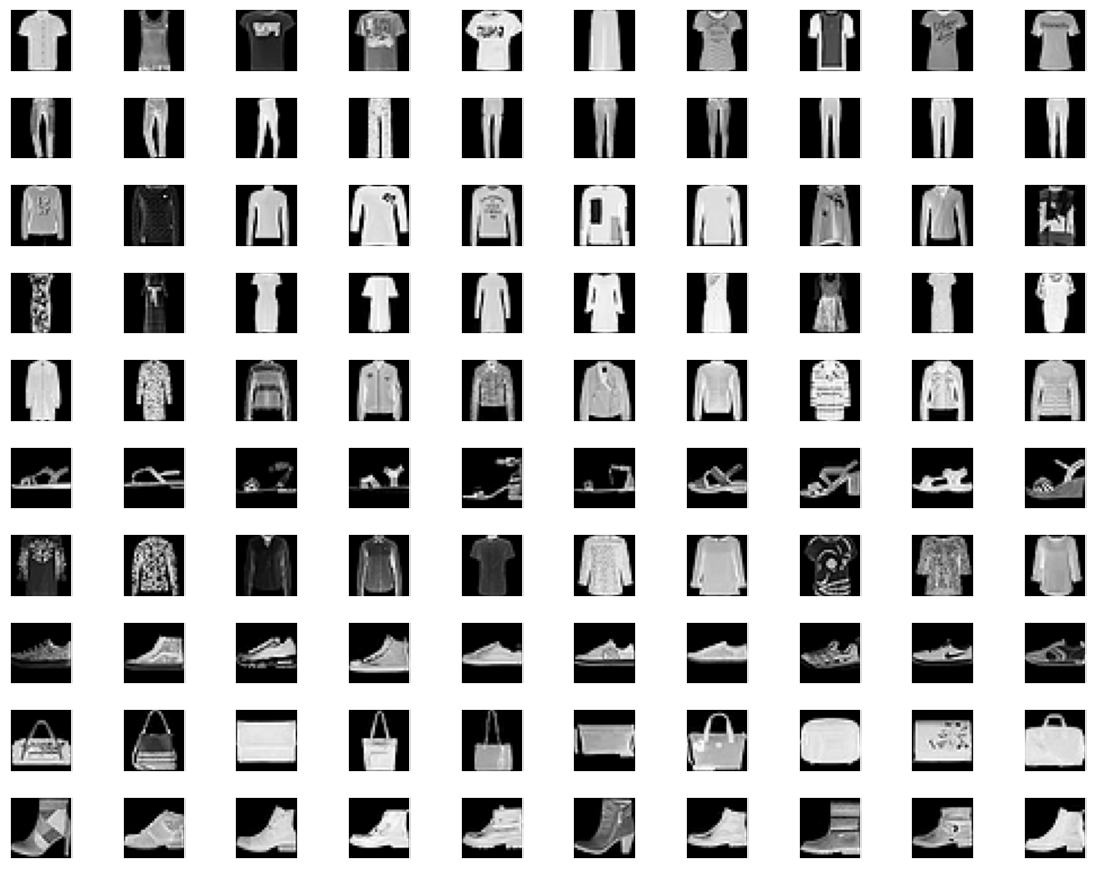

In [729]:
number_of_coulmns = 10

fig, ax = plt.subplots(ncols =number_of_coulmns, nrows=10, figsize=(12,9))


for digit in range(10):
    # select only images labeled with the current *digit*
    image_subset = test_images[predicted_label==digit]
    # draw *number_of_coulmns* random images
    image_samples = np.random.randint(low=0, high= len(image_subset), size=(number_of_coulmns, ))
    for col_index, image_index in enumerate(image_samples): 
        ax[digit, col_index].imshow(image_subset[image_index], cmap='gray')        
        ax[digit, col_index].set_xticks([]);ax[digit, col_index].set_yticks([]); 
        
        predicted_digit = np.argmax(model(image_subset[image_index].reshape(1,-1)))

In [730]:
from sklearn.metrics import classification_report
print(classification_report(test_labels, predicted_labels,digits=3))

              precision    recall  f1-score   support

           0      0.804     0.884     0.842      1000
           1      0.979     0.988     0.984      1000
           2      0.823     0.822     0.822      1000
           3      0.915     0.901     0.908      1000
           4      0.804     0.881     0.841      1000
           5      0.995     0.911     0.951      1000
           6      0.782     0.638     0.703      1000
           7      0.907     0.964     0.935      1000
           8      0.978     0.971     0.974      1000
           9      0.942     0.964     0.953      1000

    accuracy                          0.892     10000
   macro avg      0.893     0.892     0.891     10000
weighted avg      0.893     0.892     0.891     10000



<font color='blue'>As we can see the f1-score is muh lower for Tshirts, shirts, coats, and pullovers. The same thing we saw using tsne. This only further strengthens our claim that the boundaries are blurred, and it is more difficult for the model to differentiate between these products. Even looking on the predicted pictures, it's little bit hard to distinguesh between them. The cause of course is because there is a high degree of similarity between them ( similar shapes and textures, which can make it difficult for the model to accurately distinguish between them ). So, the model_1 itself, performing well overall but as it can be seen it's struggling with specific classes. How could I prevent those problems in the feature? Well, first we can add additional feateres to the pictures, such as material and maybe style ( at the end it can be translated as 1,0 the same as picture). </font> 